# 3A.mr - PIG et Paramètres (Azure) (correction)

Correction.

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Connexion au cluster

On prend le cluster [Cloudera](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td3a_cenonce_session6.html#p2). Il faut exécuter ce script pour pouvoir notifier au notebook que la variable ``params`` existe.

In [ ]:
from pyquickhelper.ipythonhelper import open_html_form
params={"blob_storage":"", "password1":"", "hadoop_server":"", "password2":"", "username":"alias"}
open_html_form(params=params,title="server + hadoop + credentials", key_save="blobhp")

In [ ]:
import pyensae
%load_ext pyensae
blobstorage = blobhp["blob_storage"]
blobpassword = blobhp["password1"]
hadoop_server = blobhp["hadoop_server"]
hadoop_password = blobhp["password2"]
username = blobhp["username"]
client, bs =  %hd_open
client, bs

(<pyensae.remote.azure_connection.AzureClient at 0x99f4b10>,
 <azure.storage.blobservice.BlobService at 0x99f4b50>)

## Exercice 1 : min, max

On ajoute deux paramètres pour construire l'histogramme entre deux valeurs ``a``,``b``. Ajouter ces deux paramètres au nom du fichier de sortie peut paraître raisonnable mais l'interpréteur a du mal à identifier les paramètres ``Undefined parameter : bins_``. On utilise des tirets.

In [ ]:
%%PIG histogramab.pig

values = LOAD '$CONTAINER/$PSEUDO/random/random.sample.txt' USING PigStorage('\t') AS (x:double);

values_f = FILTER values BY x >= $a AND x <= $b ;   -- ligne ajoutée

values_h = FOREACH values_f GENERATE x, ((int)(x / $bins)) * $bins AS h ;

hist_group = GROUP values_h BY h ;

hist = FOREACH hist_group GENERATE group, COUNT(values_h) AS nb ;

STORE hist INTO '$CONTAINER/$PSEUDO/random/histo_$bins-$a-$b.txt' USING PigStorage('\t') ;

In [ ]:
if client.exists(bs, client.account_name, "$PSEUDO/random/histo_0.1-0.2-0.8.txt"):
    r = client.delete_folder (bs, client.account_name, "$PSEUDO/random/histo_0.1-0.2-0.8.txt")
    print(r) 

In [ ]:
jid = client.pig_submit(bs, client.account_name, "histogramab.pig", 
                  params = dict(bins="0.1", a="0.2", b="0.8") )
jid

{'id': 'job_1416874839254_0202'}

In [ ]:
st = %hd_job_status jid["id"]
st["id"],st["percentComplete"],st["status"]["jobComplete"]

('job_1416874839254_0202', '100% complete', True)

In [ ]:
%hd_tail_stderr jid["id"]

In [ ]:
import os
if os.path.exists("histo.txt") : os.remove("histo.txt")
%blob_downmerge /$PSEUDO/random/histo_0.1-0.2-0.8.txt histo.txt

'histo.txt'

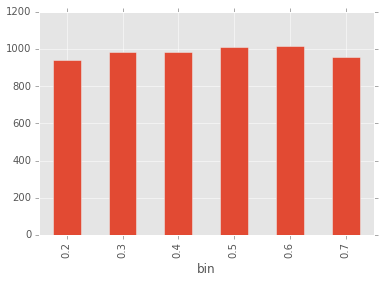

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas
df = pandas.read_csv("histo.txt", sep="\t",names=["bin","nb"])
df.plot(x="bin",y="nb",kind="bar")